# Quantum data example in Kappen (2018)

This notebook reproduces the example in Section 4 of [Kappen (2018)](https://arxiv.org/abs/1803.11278)

## Setup

In [59]:
import quimb as qu
import matplotlib.pyplot as plt
import numpy as np

In [60]:
rng = np.random.default_rng(seed=1)

In [61]:
# define number of sites == number of qubits (each site is a 2-level system)
n = 6 ## change this to 10 to reproduce the paper results

## Target state

The quantum state we set up to learn using a QBM is a thermal state (for three different temperatures) from the Hamiltonian of the 1D Heisenberg model with nearest-neighbors interactions, isotropic couplings and zero single-site fields. We report here the full Eq. (13) of the paper:

$$
H=\sum_{i=1}^n \sum_{k=x, y, z} w_i^k \sigma_i^k+\sum_{i=1, j>i}^n \sum_{k=x, y, z} w_{i j}^k \sigma_i^k \sigma_j^k
$$

where $ \sigma_j^k$ are Pauli operators on site $j$ and $n$ is the total number of sites.

The target state is generated with the Hamiltonian where
$$
w_{i j}^{x, y, z}=1 \text { for nearest neighbors and } w_{i j}^{x, y, z}=0 \text { otherwise and }  w_i^k = 0
$$

### Hamiltonian

For this example, we work under the (simplifying) assumption that each _spin direction_ will have a separate parameter, but that the interaction in a fixed _spin direction_ is isotropic along the spin chain of $n$ sites (we also include periodic boundary conditions). This amounts to the Hamiltonian of the `XYZ` Heisenberg model, but when the `x`, `y`, and `z` couplings are the same, then it is the `XXX` Heisenberg model:

In [62]:
# Fix the parameters of the hamiltonian:
# - 3 parameters for the nearest-neighbors terms
# - 3 parameters for the single-site fields
target_wij_xyz = (1.0, 1.0, 1.0)
target_wi_xyz = (0.0, 0.0, 0.0)
print(f"Spin interaction used to create target state: {target_wij_xyz}")
print(f"Field value used to create target state: {target_wi_xyz}")

Spin interaction used to create target state: (1.0, 1.0, 1.0)
Field value used to create target state: (0.0, 0.0, 0.0)


In [63]:
# quimb uses spin_operator instead of pauli operator in the Hamiltonian construction: we need a factor of 2*2 in the couplings and 2 in the fields
j = (4*j for j in target_wij_xyz)
b = (2*j for j in target_wi_xyz)
target_xxx = qu.ham_heis(n, j, b, cyclic=True, sparse=False)  # positive couplings in quimb means anti-ferromagnetic

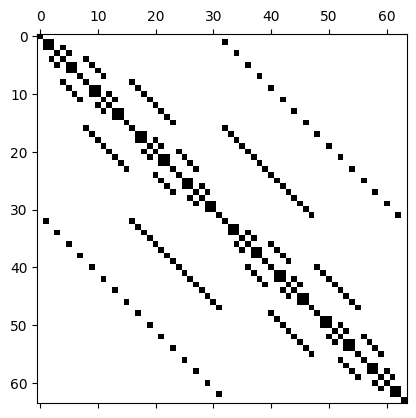

In [64]:
_ = plt.spy(target_xxx.A)

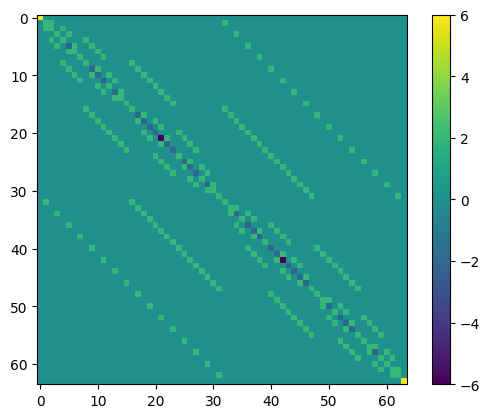

In [65]:
_ = plt.imshow(target_xxx.A, interpolation='nearest')
_ = plt.colorbar()

### Density matrix

The paper generates a density matrix from the `XXX` Hamiltonian at 3 different temperatures $T=1/\beta$, with $\beta = 1, 2, \infty$

In [66]:
target_beta = 1.0
target_eta = qu.thermal_state(target_xxx, target_beta, precomp_func=True)

In [67]:
target_eta_beta1 = target_eta(1.0)

In [68]:
target_eta_beta2 = target_eta(2.0)

The $\beta=\infty$ thermal state is the ground state

In [69]:
# for the anti-ferromagnetic case the groundstate should be unique
gs = qu.groundstate(target_xxx)
target_eta_betainfty = qu.dop(gs)  # equivalent to (gs @ gs.H)

**Note** this target state is a pure state $\eta (\beta = \infty) = \psi_{\mathrm{g.s.}}\psi^{\dag}_{\mathrm{g.s.}}$ and a QBM would need to have diverging parameters in order to _exactly_ reproduce it

The ground state density matrix has rank 1 as expected:

In [70]:
np.linalg.matrix_rank(target_eta_betainfty.A)

1

in contrast to the finite-temperature states

In [71]:
np.linalg.matrix_rank(target_eta_beta1.A)

64

Plot of the ground state wavefunction (amplitudes) $\langle s | \psi_\mathrm{g.s.}\rangle$ where $s$ are the $2^n$ computational states

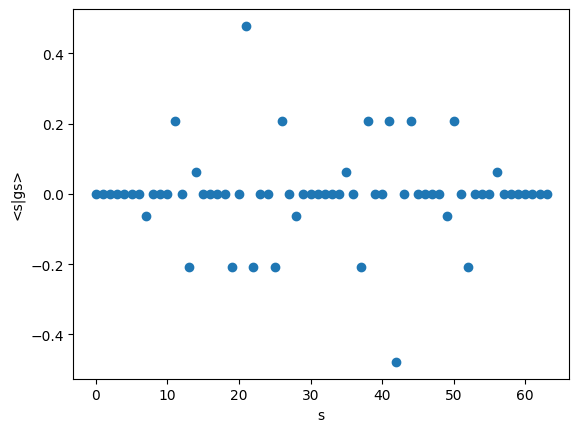

In [72]:
_ = plt.plot(gs.A.flatten(),'o')
_ = plt.xlabel('s')
_ = plt.ylabel('<s|gs>')

## Quantum Boltzmann Machine model

Following the paper we now define the QBM based on the same `XYZ` Heisenberg Hamiltonian used to define the target state. We let the 3 parameters for each _spin direction_ to have arbitrary values.


In [73]:
# parameters to learn. Set initial values at random
j = tuple(rng.normal(size=3))
b = tuple(rng.normal(size=3))
print(f"Spin interaction: {j}")
print(f"Field value: {b}")

Spin interaction: (0.345584192064786, 0.8216181435011584, 0.33043707618338714)
Field value: (-1.303157231604361, 0.9053558666731177, 0.4463745723640113)


In [74]:
qbm_xyz = qu.ham_heis(n, j, b, cyclic=True)

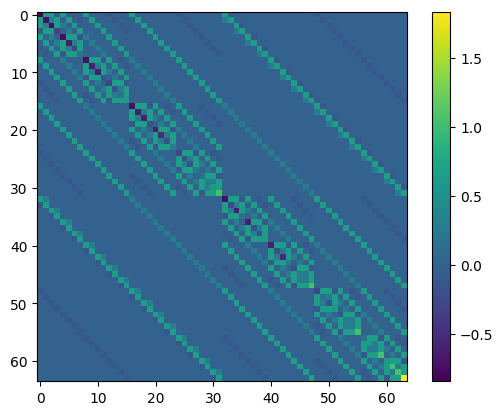

In [75]:
# plot only the real part
_ = plt.imshow(qbm_xyz.A.real, interpolation='nearest')
_ = plt.colorbar()

### Gibbs state

The corresponding Gibbs state for this initial Hamiltonian is  

$$
\rho_{\theta} = \frac{e^{\mathcal{H}_\theta}}{Z}
$$

In [76]:
rho_qbm = qu.thermal_state(qbm_xyz, -1.0)

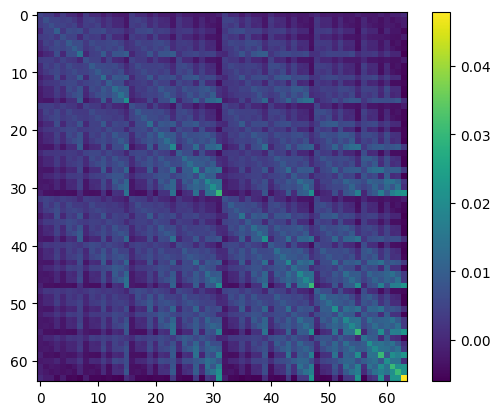

In [77]:
_ = plt.imshow(rho_qbm.A.real, interpolation='nearest')
_ = plt.colorbar()

## Quantum statistics

To perform training of the QBM parameters we need to be able to compute the expectation values of various terms in the QBM Hamiltonian. 

These are called **quantum statistics** and they are 

$$
\left\langle\sigma_i^k\right\rangle_{\eta_\beta}=0 \text { and }\left\langle\sigma_i^k \sigma_j^k\right\rangle_{\eta_\beta}
$$

for the target $\eta_\beta$ state

We have simplified our model to only require 6 quantum statistics, one for each parameter:

$$
\left\langle \sum_i^n \sigma_i^k\right\rangle \text {for each } k \in \{ x,y,z\}
$$

$$
\left\langle \sum_{\langle i, j\rangle} \sigma_i^k\sigma_j^k\right\rangle \text {for each } k \in \{ x,y,z\}
$$

In [78]:
# function to create the two-site operators for a fixed spin direction
def h_two_sites(n, direction):
    assert direction in "xyz", "Wrong direction. Must be one of x,y, or z"
    dims = (2,) * n
    two_site_term = qu.kron(qu.pauli(direction), qu.pauli(direction))

    def gen_term(i):
        if i == (n - 1):
            return qu.ikron(qu.pauli(direction), dims, [0, n - 1])
        return qu.ikron(two_site_term, dims, [i, i + 1])

    return sum(map(gen_term, range(0, n)))


Test that the function above reproduces the correct terms in the Heisenberg Hamiltonian:

In [79]:
# generate only the terms with the Pauli Z operators
h0 = h_two_sites(n,'z')

In [80]:
# compare with quimb by generating the Heis hamiltonian with only couplings between Pauli Z terms (rescaling the coupling due to Spin Z being 1/2 Pauli Z)
test_h0 = qu.ham_heis(n,j=(0,0,4), b=0.0, cyclic=True, sparse=False)

In [81]:
np.allclose(h0.A.real, test_h0.A.real)

True

In [82]:
# function to create the single-site operators for a fixed spin direction
def h_single_site(n, direction):
    assert direction in "xyz", "Wrong direction. Must be one of x,y, or z"
    dims = (2,) * n
    single_site_term = qu.pauli(direction)
    def gen_term(i):
        return qu.ikron(single_site_term, dims, [i])
    return sum(map(gen_term, range(0,n)))

In [83]:
# test
h1 = h_single_site(n,'x')
test_h1 = qu.ham_heis(n, j=0.0, b=(-2,0,0), cyclic=True, sparse=False)
np.allclose(h1.A.real, test_h1.A.real)

True

Another approach is to cleverly manipulate the `quimb` function `ham_heis` for the 1D Heisenberg model Hamiltonian

In [84]:
PauliX = qu.ham_heis(n, j=0, b=(-2,0,0), cyclic=True, sparse=False)  # sum Pauli_X over all sites
PauliY = qu.ham_heis(n, j=0, b=(0,-2,0), cyclic=True, sparse=False)  # sum Pauli_Y over all sites
PauliZ = qu.ham_heis(n, j=0, b=(0,0,-2), cyclic=True, sparse=False)  # sum Pauli_Z over all sites

In [85]:
np.allclose(h1,PauliX)

True

In [86]:
PauliXX = qu.ham_heis(n, j=(4,0,0), b=0, cyclic=True, sparse=False)  # sum Pauli_X x Pauli_X over all sites
PauliYY = qu.ham_heis(n, j=(0,4,0), b=0, cyclic=True, sparse=False)  # sum Pauli_Y x Pauli_Y over all sites
PauliZZ = qu.ham_heis(n, j=(0,0,4), b=0, cyclic=True, sparse=False)  # sum Pauli_Z x Pauli_Z over all sites

In [87]:
np.allclose(h0,PauliZZ)

True

### Generate all terms 

In [88]:
s = [h_single_site(n,d) for d in 'xyz']
ss = [h_two_sites(n,d) for d in 'xyz']

We can have a look at the quantum statistics. The single-site operators should all have zero expectation values on the target density matrices because we do not include any external field in the original Hamiltonian

In [89]:
# single site
[qu.expec(target_eta_beta1, i) for i in s]

[1.102302932309248e-17, 1.222912463348638e-19j, -2.459701622509723e-17]

The two-sites operators should have all the same expectation value because the three spin directions have the same interaction couplings

In [90]:
# two sites
[qu.expec(target_eta_beta1, i) for i in ss]

[-3.5502047332219147, -3.5502047332219147, -3.5502047332219164]

In [91]:
# two sites on the ground state
[qu.expec(target_eta_betainfty, i) for i in ss]

[-3.7370341836426624, -3.7370341836426624, -3.737034183642663]

In [92]:
# single site on the ground state
[qu.expec(target_eta_betainfty, i) for i in s]

[6.652762880061087e-31, -1.0880721154991988e-32j, 5.6845197314364006e-33]

## Training of the QBM

We use the `compute_grads` function from the [01_trainng.ipynb notebook](./01_training.ipynb):

In [93]:
def compute_grads(hi, eta, rho):
    """Compute gradients given a list of hamiltonian terms (operators)

    Args:
        hi (List, Tuple): A list of hamiltonian terms
        eta (Any): The target density matrix
        rho (Any): The QBM density matrix

    Returns:
        np.ndarray: The array of the gradients
    """
    grads = []
    for h in hi:
        rho_expect = qu.expec(rho,h)
        eta_expect = qu.expec(eta,h)
        grads.append(rho_expect-eta_expect)
    return np.array(grads)

In [94]:
print(f"Gradients: {compute_grads(s+ss, target_eta_beta1, rho_qbm)}")

Gradients: [ 3.33072986+0.00000000e+00j -2.84784546-1.22291246e-19j
 -1.13344334+0.00000000e+00j  5.54505061+0.00000000e+00j
  5.38270733+0.00000000e+00j  3.86805537+0.00000000e+00j]


In [95]:
# gradient descent!
def update_params(params, grads, gamma):
    return params - gamma * grads

We also need a way to reconstruct the QBM given the new parameters

In [96]:
def build_qbm_hamiltonian(params, operators):
    return sum([p*o for p,o in zip(params,operators)])

Test by comparing the constructed Hamiltonian from the parameters with the Hamiltonian build using `quimb.ham_heis` (remember to rescale the parameters due to the normalization difference between `spin_operator()` and `pauli()`)

In [97]:
jnew = [i/4 for i in j]
bnew = [-i/2 for i in b]
p = jnew+bnew
o = ss+s
qbm_h = build_qbm_hamiltonian(p,o)

In [98]:
np.allclose(qbm_h,qbm_xyz)

True

The paper does not specify the learning rate, but figure 1 shows training curves of up to 2000 iterations

In [99]:
# learning rate
gamma = 0.2
# number of epochs
epochs = 2000

In [100]:
# function to compute the quantum relative entropy between the target density and the QBM
# since we will deal with a pure state later, which has zero eigenvalues and its log goes ton NAN, we implement a fix
def qre(eta, h_qbm):
    """Quantum relative entropy

    Args:
        eta (Any): Target density matrix
        h_qbm (Any): Hamiltonian of the QBM
    """
    # check if rank<nqubits
    if np.linalg.matrix_rank(eta.A) == 1:
        h = 0
    else:
        evals = qu.eigvalsh(eta)
        h = np.sum(evals * np.log(evals))
    # use log base e all the way
    evals = qu.eigvalsh(h_qbm)
    z = np.sum(np.exp(evals))
    eta_stat = qu.expec(eta, h_qbm)
    return h-eta_stat+qu.log(z)


### Train for $\beta=1$

In [101]:
target_eta = target_eta_beta1

In [102]:
# stop when gradient is smaller than epsilon, at the final number of epochs
eps = 1e-10
# keep track of loss and gradients
qre_hist = []
grad_hist = []
# init params
p = j+b
# operators
o = ss+s
for i in range(epochs):
    # create qbm hamiltonians
    qbm_h = build_qbm_hamiltonian(p,o)
    # qbm_h = qbm_h.real
    qre_hist.append(qre(target_eta, qbm_h))
    # create qbm state
    rho = qu.thermal_state(qbm_h, -1.0)
    # grad and update
    grads = compute_grads(o, target_eta, rho)
    grad_hist.append(np.abs(grads))
    p = update_params(p, grads, gamma)
    # print diagnostic
    if (i % 10)==0:
        print(f"Quantum relative entropy: {qre_hist[-1]}")
        print(f"Max abs gradient: {np.max(grad_hist[-1])}")
    if np.max(grad_hist[-1]) < eps:
        print(f"Max gradient smaller than precision")
        break
print(f"Final parameters: {p}")

Quantum relative entropy: 17.861734254529363
Max abs gradient: 7.0097154970183615
Quantum relative entropy: 0.00903985152785225
Max abs gradient: 0.08131497090378853
Quantum relative entropy: 0.0008405681236549611
Max abs gradient: 0.025315494545979974
Quantum relative entropy: 0.00010278290825915803
Max abs gradient: 0.009061222374977494
Quantum relative entropy: 1.3581865188072584e-05
Max abs gradient: 0.0033485820730783833
Quantum relative entropy: 1.845806599121147e-06
Max abs gradient: 0.0012482253376231807
Quantum relative entropy: 2.5395418923324087e-07
Max abs gradient: 0.0004664611529830993
Quantum relative entropy: 3.516353075383449e-08
Max abs gradient: 0.0001744472609974544
Quantum relative entropy: 4.887086291205378e-09
Max abs gradient: 6.525469088730847e-05
Quantum relative entropy: 6.808260621937734e-10
Max abs gradient: 2.441122049390196e-05
Quantum relative entropy: 9.49960110574466e-11
Max abs gradient: 9.132222438486015e-06
Quantum relative entropy: 1.32640565198016

In [103]:
beta1_qre = qre_hist
beta1_grads = grad_hist
beta1_params = p

Text(0.5, 0.98, '$\\beta=1$')

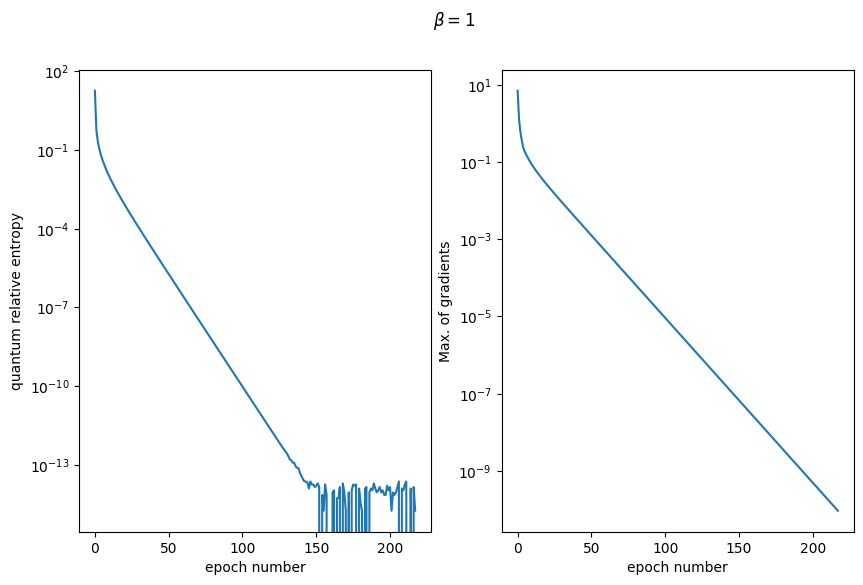

In [104]:
fig, ax = plt.subplots(ncols=2,figsize=(10,6))
ax[0].plot(qre_hist)
ax[0].set_xlabel("epoch number")
ax[0].set_ylabel("quantum relative entropy")
ax[0].set_yscale('log')
ax[1].plot(np.max(grad_hist,axis=1))
ax[1].set_xlabel("epoch number")
ax[1].set_ylabel("Max. of gradients")
ax[1].set_yscale('log')
fig.suptitle(r"$\beta=1$")


Here are the learned Hamiltonian parameters:

In [105]:
print(f"Learned interaction terms: {beta1_params[:3]}")
print(f"Learned fields terms: {beta1_params[3:]}")

Learned interaction terms: [-1.+0.j -1.+0.j -1.+0.j]
Learned fields terms: [-1.78411076e-10+3.49186046e-19j  6.09451105e-12+1.08013573e-17j
  4.32232011e-11+4.59943785e-19j]


They match with the target Hamiltonian up to the rescaling given by $\beta=-1$ in the QBM Gibbs state definition.

### Train for $\beta=2$

In [106]:
target_eta = target_eta_beta2

In [107]:
# stop when gradient is smaller than epsilon, at the final number of epochs
eps = 1e-10
# keep track of loss and gradients
qre_hist = []
grad_hist = []
# init params
p = j+b
# operators
o = ss+s
for i in range(epochs):
    # create qbm hamiltonians
    qbm_h = build_qbm_hamiltonian(p,o)
    # qbm_h = qbm_h.real
    qre_hist.append(qre(target_eta, qbm_h))
    # create qbm state
    rho = qu.thermal_state(qbm_h, -1.0)
    # grad and update
    grads = compute_grads(o, target_eta, rho)
    grad_hist.append(np.abs(grads))
    p = update_params(p, grads, gamma)
    # print diagnostic
    if (i % 10)==0:
        print(f"Quantum relative entropy: {qre_hist[-1]}")
        print(f"Max abs gradient: {np.max(grad_hist[-1])}")
    if np.max(grad_hist[-1]) < eps:
        print(f"Max gradient smaller than precision")
        break
print(f"Final parameters: {p}")

Quantum relative entropy: 18.80131662970301
Max abs gradient: 7.185123033095685
Quantum relative entropy: 0.09575098072188482
Max abs gradient: 0.12177417842754057
Quantum relative entropy: 0.04606879178378165
Max abs gradient: 0.06429357142724923
Quantum relative entropy: 0.028226411437152876
Max abs gradient: 0.04396076437187135
Quantum relative entropy: 0.01917303161149775
Max abs gradient: 0.03308526197016759
Quantum relative entropy: 0.013811296924345129
Max abs gradient: 0.02625211785283721
Quantum relative entropy: 0.010338261469410526
Max abs gradient: 0.02154535914238709
Quantum relative entropy: 0.007951986064249184
Max abs gradient: 0.01810325543663094
Quantum relative entropy: 0.006242252320205921
Max abs gradient: 0.015477307136100293
Quantum relative entropy: 0.00497824137404379
Max abs gradient: 0.01340986625488938
Quantum relative entropy: 0.00402072917486862
Max abs gradient: 0.011741927789458817
Quantum relative entropy: 0.003281159696513214
Max abs gradient: 0.010369

In [108]:
beta2_qre = qre_hist
beta2_grads = grad_hist
beta2_params = p

Text(0.5, 0.98, '$\\beta=2$')

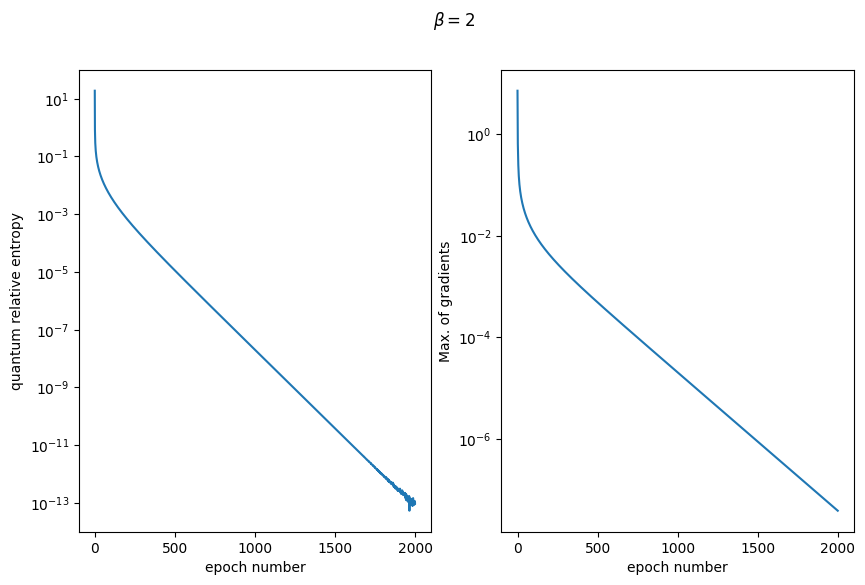

In [109]:
fig, ax = plt.subplots(ncols=2,figsize=(10,6))
ax[0].plot(qre_hist)
ax[0].set_xlabel("epoch number")
ax[0].set_ylabel("quantum relative entropy")
ax[0].set_yscale('log')
ax[1].plot(np.max(grad_hist,axis=1))
ax[1].set_xlabel("epoch number")
ax[1].set_ylabel("Max. of gradients")
ax[1].set_yscale('log')
fig.suptitle(r"$\beta=2$")

In [110]:
print(f"Learned interaction terms: {beta2_params[:3]}")
print(f"Learned fields terms: {beta2_params[3:]}")

Learned interaction terms: [-1.99999877+0.j -1.99999877+0.j -1.99999877+0.j]
Learned fields terms: [-3.40640871e-08-9.25669089e-20j  1.18852483e-09+1.62061867e-18j
  8.56620133e-09+7.76329248e-22j]


They match the target Hamiltonian up to the rescaling of the target $\beta=2$ and the QBM Gibbs state definition ($\beta=-1$).

### Target $\beta=\infty$

In [111]:
target_eta = target_eta_betainfty

In [112]:
# stop when gradient is smaller than epsilon or at the final number of epochs
eps = 1e-10
# keep track of loss and gradients
qre_hist = []
grad_hist = []
# init params
p = j+b
# operators
o = ss+s
for i in range(epochs):
    # create qbm hamiltonians
    qbm_h = build_qbm_hamiltonian(p,o)
    # qbm_h = qbm_h.real
    qre_hist.append(qre(target_eta, qbm_h))
    # create qbm state
    rho = qu.thermal_state(qbm_h, -1.0)
    # grad and update
    grads = compute_grads(o, target_eta, rho)
    grad_hist.append(np.abs(grads))
    p = update_params(p, grads, gamma)
    # print diagnostic
    if (i % 100)==0:
        print(f"--- {i} ---")
        print(f"Quantum relative entropy: {qre_hist[-1]}")
        print(f"Max abs gradient: {np.max(grad_hist[-1])}")
    if np.max(grad_hist[-1]) < eps:
        print(f"Max gradient smaller than precision")
        break
print(f"Final parameters: {p}")

--- 0 ---
Quantum relative entropy: 18.899473222176674
Max abs gradient: 7.19654494743911
--- 100 ---
Quantum relative entropy: 0.018517862907174276
Max abs gradient: 0.016898746372596918
--- 200 ---
Quantum relative entropy: 0.009599091616628641
Max abs gradient: 0.008758136527083682
--- 300 ---
Quantum relative entropy: 0.0064831117316188624
Max abs gradient: 0.0059156646700344595
--- 400 ---
Quantum relative entropy: 0.004895050190459216
Max abs gradient: 0.004466970576183726
--- 500 ---
Quantum relative entropy: 0.00393210371812458
Max abs gradient: 0.0035884663040253173
--- 600 ---
Quantum relative entropy: 0.003285805923344043
Max abs gradient: 0.00299880014605991
--- 700 ---
Quantum relative entropy: 0.0028220023230893787
Max abs gradient: 0.0025756103134608743
--- 800 ---
Quantum relative entropy: 0.002472951465495754
Max abs gradient: 0.0022571075635564597
--- 900 ---
Quantum relative entropy: 0.0022007504681127443
Max abs gradient: 0.0020087176303857923
--- 1000 ---
Quantum r

In [113]:
betainfty_qre = qre_hist
betainfty_grads = grad_hist
betainfty_params = p

Text(0.5, 0.98, '$\\beta=\\infty$')

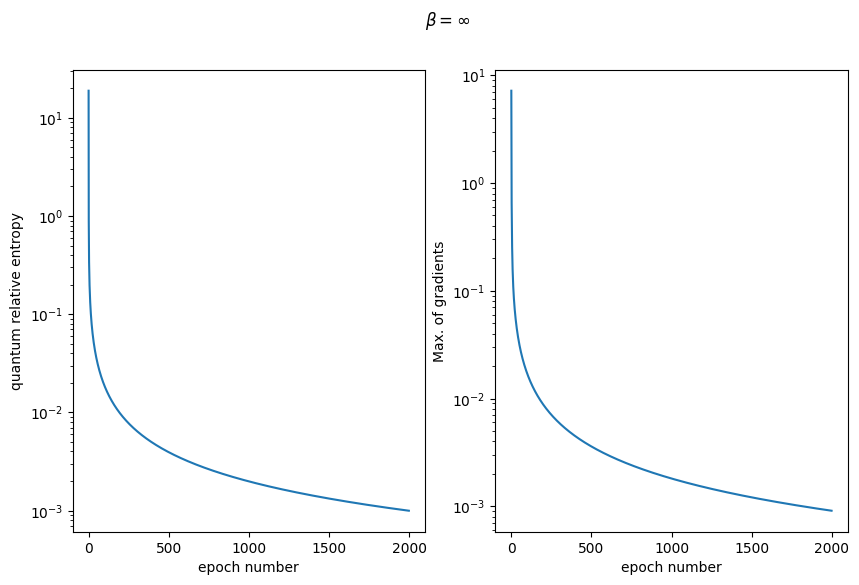

In [114]:
fig, ax = plt.subplots(ncols=2,figsize=(10,6))
ax[0].plot(qre_hist)
ax[0].set_xlabel("epoch number")
ax[0].set_ylabel("quantum relative entropy")
ax[0].set_yscale('log')
ax[1].plot(np.max(grad_hist,axis=1))
ax[1].set_xlabel("epoch number")
ax[1].set_ylabel("Max. of gradients")
ax[1].set_yscale('log')
fig.suptitle(r"$\beta=\infty$")

In [115]:
print(f"Learned interaction terms: {betainfty_params[:3]}")
print(f"Learned fields terms: {betainfty_params[3:]}")

Learned interaction terms: [-2.92473413+0.j -2.92473413+0.j -2.92473413+0.j]
Learned fields terms: [-1.31837724e-03+0.00000000e+00j  4.60692452e-05-4.35228846e-30j
  3.32365365e-04+0.00000000e+00j]


The parameters are not learned correctly because of the infinite $\beta$ value, but the gradients are still very small, meaning that we can reconstruct the quantum statistics accurately.

### Figure 1: learning curves

Reproduce Fig. 1(b) in the paper

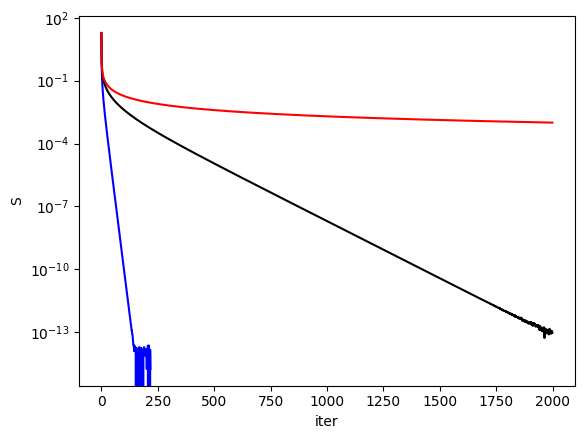

In [116]:
fig, ax = plt.subplots()
ax.plot(beta1_qre, 'b')
ax.plot(beta2_qre, 'k')
ax.plot(betainfty_qre, 'r')
ax.set_xlabel("iter")
ax.set_ylabel("S")
ax.set_yscale('log')